In [57]:
##Install Prerequesites
# %pip install -q git+https://github.com/huggingface/transformers.git
# %pip install -q timm

In [58]:
import torch
import numpy as np
from huggingface_hub import hf_hub_download
from PIL import Image
from transformers import DetrFeatureExtractor
from transformers import TableTransformerForObjectDetection

In [59]:
def scaler(box,xscale,yscale,xmax,ymax):
    box[0]*=1-xscale
    box[1]*=1-yscale
    box[2]*=1+xscale
    box[3]*=1+yscale
    if box[2]>xmax:
        box[2] = xmax
    if box[3]>ymax:
        box[3] = ymax
    return box

In [71]:
def table_detection(image):
    width, height = image.size
    feature_extractor = DetrFeatureExtractor()
    encoding = feature_extractor(image, return_tensors="pt")
    model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

    with torch.no_grad():
        outputs = model(**encoding)

    results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

    cropped_img = []
    scale = 0.05
    all_boxes = []
    for i in range(len(results['scores'])):
        bounding_box = scaler(results['boxes'][i].tolist(),scale,scale,width,height)
        all_boxes.append(bounding_box)
        cropped_img.append(image.crop(bounding_box))
    
    for i in all_boxes:
        mask_height = int(i[3] - i[1])
        mask_width = int(i[2] - i[0])
        square = np.full((mask_height, mask_width),255)
        square_img = Image.fromarray(square.astype(np.uint8))
        image.paste(square_img,(int(i[0]),int(i[1])))
        display(image)
        
    return cropped_img,image

In [61]:
def table_structure_detection(image):
    width, height = image.size
    feature_extractor = DetrFeatureExtractor()
    encoding = feature_extractor(image, return_tensors="pt")
    model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")
    
    with torch.no_grad():
        outputs = model(**encoding)
    target_sizes = [image.size[::-1]]
    results = feature_extractor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[0]
    
    output = {'col_data':[],'row_data':[],'col_header_data':[],'row_header_data':[]}
    
    #plot_results(model,image, results['scores'], results['labels'], results['boxes'])
    y_scale = 0.03
    for i in range(len(results['boxes'])):
        if results['labels'][i] == 1:
            bounding_box = scaler(results['boxes'][i].tolist(),1,y_scale,width,height)
            output['col_data'].append(image.crop(bounding_box))
        elif results['labels'][i] == 2:
            bounding_box = scaler(results['boxes'][i].tolist(),1,y_scale,width,height)
            output['row_data'].append(image.crop(bounding_box))
        elif results['labels'][i] == 3:
            bounding_box = scaler(results['boxes'][i].tolist(),1,y_scale,width,height)
            output['col_header_data'].append(image.crop(bounding_box))
        elif results['labels'][i] == 4:
            bounding_box = scaler(results['boxes'][i].tolist(),1,y_scale,width,height)
            output['row_header_data'].append(image.crop(bounding_box))
    
    return output

In [62]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(model,pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [63]:
from paddleocr import PaddleOCR, draw_ocr # main OCR dependencies
from matplotlib import pyplot as plt # plot images
import cv2 #opencv
import os # folder directory navigation
from numpy import asarray

ocr_model = PaddleOCR(lang='en')

def extract_data(split_table):
    output = []
    for i in split_table:
        #Ran OCR to get a split list output
        #output.append(ocr_model.ocr(i))
        numpydata = asarray(i)
        res = ocr_model.ocr(numpydata, cls=True)
        for i,item in enumerate(res[0]):
            res[0][i][1] = res[0][i][1][0]
        # print("result")
        # print(res)
        output.append(res)

    return output

[2023/06/29 10:06:34] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/jovyan/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/jovyan/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_pa

In [64]:
def get_table_data(img):
    #Locate tables on the image
    tables,image_no_table = table_detection(img)
    
    #Figure out headers and data inside the table
    split_tables = {}
    for i,table in enumerate(tables):
        split_tables[i] = table_structure_detection(table)
    
    # #Perform OCR on each table detected
    data = {}
    for i,split_table in split_tables.items():
        data[0] = {}
        if len(split_table['col_header_data'])>0:
            data[i]['header_data'] = extract_data(split_table['col_header_data'])
        if len(split_table['row_data'])>0:
            data[i]['row_data'] = extract_data(split_table['row_data'])

    #perform OCR on the rest of the image
    data_no_table = extract_data([image_no_table])
    data["data_no_table"] = data_no_table[0]
    return data

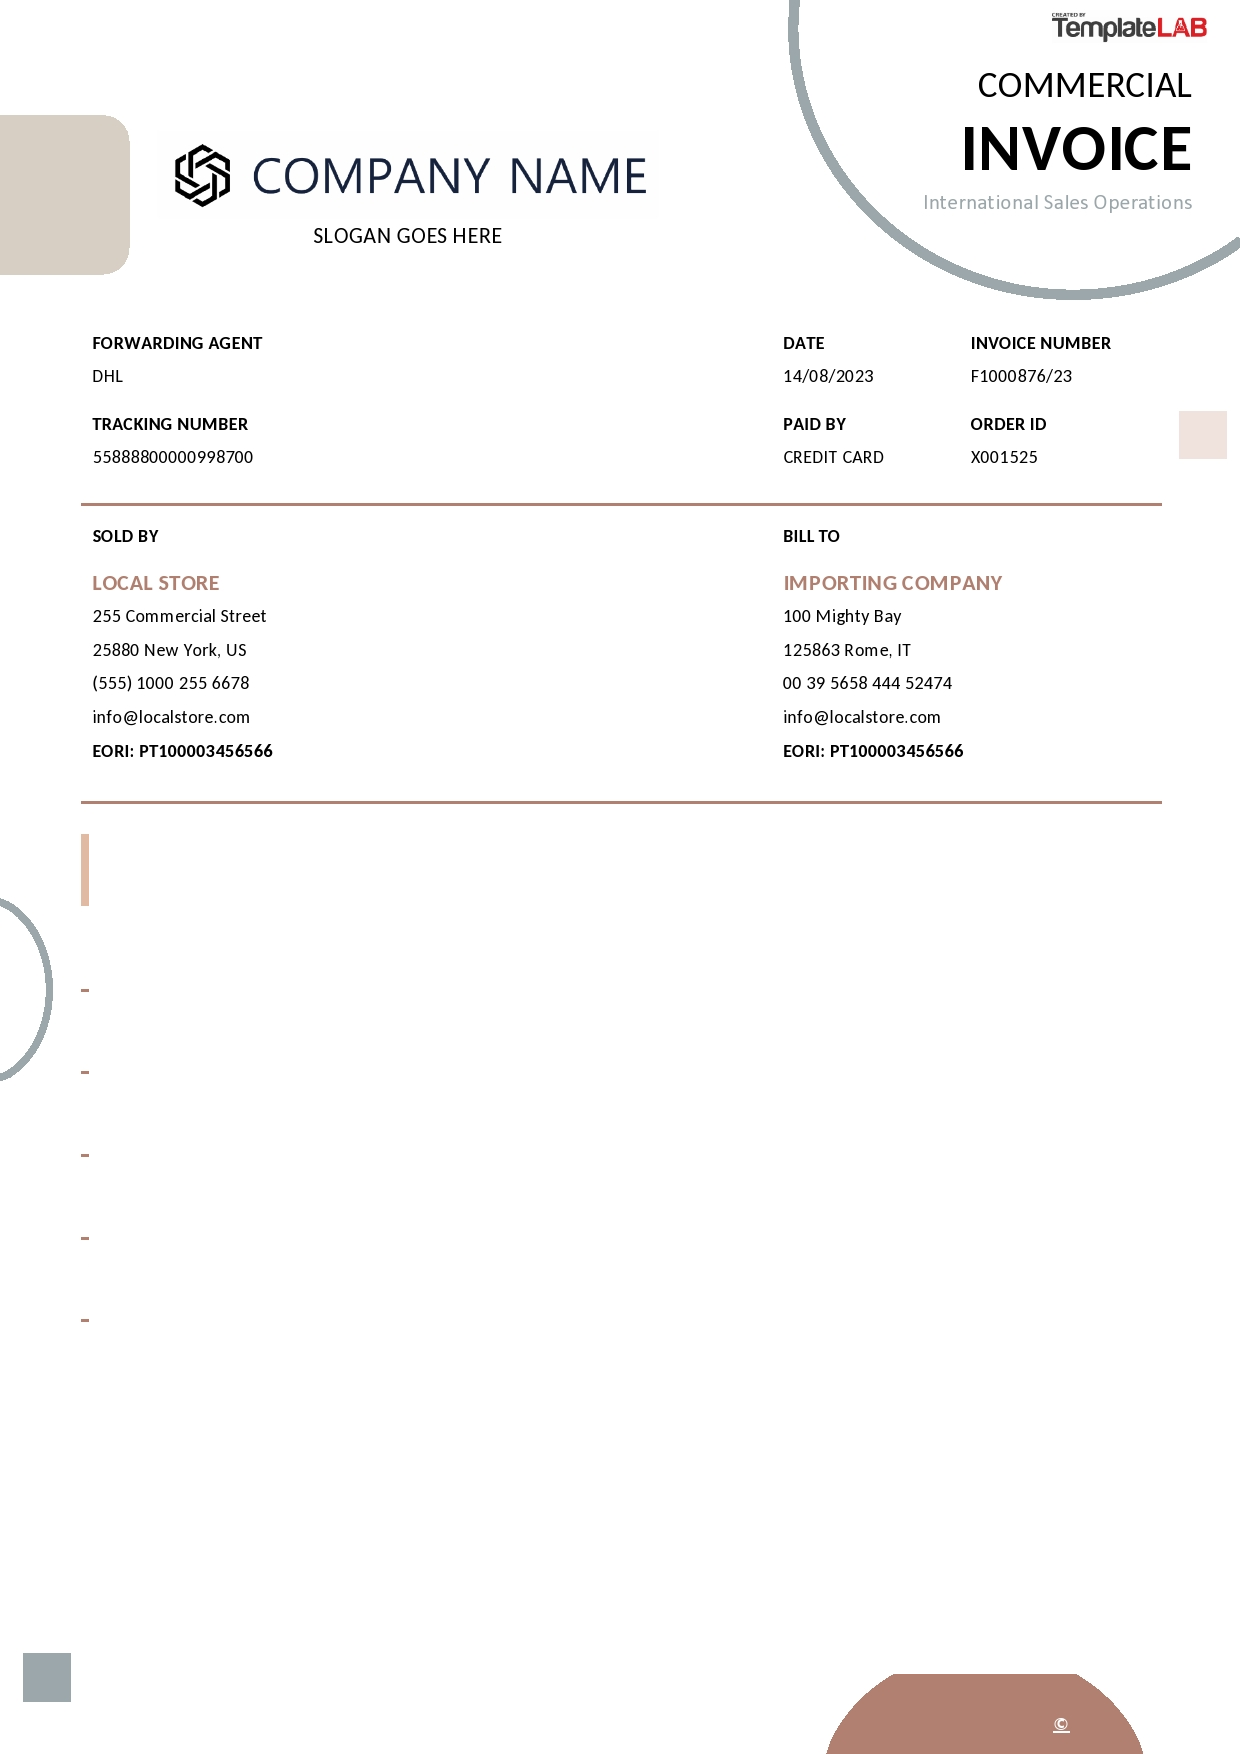

[2023/06/29 10:13:00] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/06/29 10:13:00] ppocr DEBUG: dt_boxes num : 5, elapse : 0.013384819030761719
[2023/06/29 10:13:00] ppocr DEBUG: rec_res num  : 5, elapse : 0.17050957679748535
[2023/06/29 10:13:00] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/06/29 10:13:00] ppocr DEBUG: dt_boxes num : 5, elapse : 0.034754037857055664
[2023/06/29 10:13:01] ppocr DEBUG: rec_res num  : 5, elapse : 0.5800714492797852
[2023/06/29 10:13:01] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/06/29 10:13:01] ppocr DEBUG: dt_boxes num : 6, elapse : 0.03505754470825195
[2023/06/29 10:13:01] ppocr DEBUG: rec_res num  : 6, elapse : 0.2531461715698242
[2023/06/29 10:13:01] ppocr WARNING: Since the angle classifi

In [72]:
file_path = "../data/invoice_sample.jpg"
image = Image.open(file_path).convert("RGB")
data = get_table_data(image)
print(data)

In [68]:
#paddleocr ouputs as a nested list so convert to dict for easier parseing to json 

formatted_rows = {}
for j,row in enumerate(data[0]['row_data']):
    formatted_rows[j] = {}
    for i,entry in enumerate(row[0]):
        formatted_rows[j][i] = {}
        formatted_rows[j][i]['boundingBox'] = entry[0]
        formatted_rows[j][i]['data'] = entry[1]
        # print(entry[1])
data[0]['row_data'] = formatted_rows

formatted_header = {}
for i,entry in enumerate(data[0]['header_data'][0][0]):
    formatted_header[i] = {}
    formatted_header[i]['boundingBox'] = entry[0]
    formatted_header[i]['data'] = entry[1]

data[0]['header_data'] = formatted_header


In [69]:
#makes data into json object

import json

def preprocess_data(data):
    

    
    # Indent the data
    indented_data = json.dumps(data, indent=4)
    
    # Load the indented data as a JSON object
    json_object = json.loads(indented_data)
    
    return json_object
    
preprocessed_data = preprocess_data(data)
preprocessed_data

{'0': {'header_data': {'0': {'boundingBox': [[2.0, 5.0],
     [80.0, 1.0],
     [81.0, 23.0],
     [3.0, 27.0]],
    'data': 'PRODUCT'},
   '1': {'boundingBox': [[445.0, 4.0],
     [515.0, 4.0],
     [515.0, 25.0],
     [445.0, 25.0]],
    'data': 'HS CODE'},
   '2': {'boundingBox': [[612.0, 3.0],
     [662.0, 3.0],
     [662.0, 25.0],
     [612.0, 25.0]],
    'data': 'UNITS'},
   '3': {'boundingBox': [[733.0, 6.0],
     [820.0, 6.0],
     [820.0, 22.0],
     [733.0, 22.0]],
    'data': 'UNIT PRICE'},
   '4': {'boundingBox': [[1010.0, 3.0],
     [1063.0, 3.0],
     [1063.0, 25.0],
     [1010.0, 25.0]],
    'data': 'TOTAL'}},
  'row_data': {'0': {'0': {'boundingBox': [[5.0, 22.0],
      [215.0, 22.0],
      [215.0, 39.0],
      [5.0, 39.0]],
     'data': 'Description of the goods'},
    '1': {'boundingBox': [[692.0, 33.0],
      [823.0, 33.0],
      [823.0, 55.0],
      [692.0, 55.0]],
     'data': 'Sales Tax (VAT)'},
    '2': {'boundingBox': [[989.0, 34.0],
      [1064.0, 31.0],
      

In [70]:
preprocessed_data['0']['header_data']['0']

{'boundingBox': [[2.0, 5.0], [80.0, 1.0], [81.0, 23.0], [3.0, 27.0]],
 'data': 'PRODUCT'}